# удалим примеры, на которых указано больше четырех парковочных мест (как правило, это изображения с уличных камер, а не с автомобиля)

In [1]:
import os

# Функция для подсчета объектов в аннотации
def count_objects_in_annotation(annotation_path):
    with open(annotation_path, 'r') as f:
        lines = f.readlines()
    return len(lines)

# Функция для удаления файлов с более чем 4 объектами
def remove_images_with_too_many_objects(images_folder, annotations_folder):
    # Получаем все файлы аннотаций
    annotation_files = [f for f in os.listdir(annotations_folder) if f.endswith('.txt')]

    for annotation_file in annotation_files:
        annotation_path = os.path.join(annotations_folder, annotation_file)
        num_objects = count_objects_in_annotation(annotation_path)

        # Если объектов больше 4, удаляем соответствующие изображения и аннотации
        if num_objects > 4:
            # Получаем имя файла изображения
            image_file = annotation_file.replace('.txt', '.jpg')  # или .png, в зависимости от формата
            image_path = os.path.join(images_folder, image_file)

            # Удаляем изображение и аннотацию
            if os.path.exists(image_path):
                os.remove(image_path)
                print(f"Удалено изображение: {image_path}")
            os.remove(annotation_path)
            print(f"Удалена аннотация: {annotation_path}")

# Запускаем процесс удаления
remove_images_with_too_many_objects('Parking Finder.v1i.yolov8/test/images', 'Parking Finder.v1i.yolov8/test/labels')
remove_images_with_too_many_objects('Parking Finder.v1i.yolov8/train/images', 'Parking Finder.v1i.yolov8/train/labels')
remove_images_with_too_many_objects('Parking Finder.v1i.yolov8/valid/images', 'Parking Finder.v1i.yolov8/valid/labels')

Удалено изображение: Parking Finder.v1i.yolov8/test/images/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-771_jpg.rf.b3d47dbfa00c2cca36bc10f129624ef0.jpg
Удалена аннотация: Parking Finder.v1i.yolov8/test/labels/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-771_jpg.rf.b3d47dbfa00c2cca36bc10f129624ef0.txt
Удалено изображение: Parking Finder.v1i.yolov8/test/images/VID20221114141858_mp4-23_jpg.rf.859b4dfe2800046828e87977e4c63f84.jpg
Удалена аннотация: Parking Finder.v1i.yolov8/test/labels/VID20221114141858_mp4-23_jpg.rf.859b4dfe2800046828e87977e4c63f84.txt
Удалено изображение: Parking Finder.v1i.yolov8/test/images/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-906_jpg.rf.11bdb43d94c40e64eb9dcb3e70c5b1d8.jpg
Удалена аннотация: Parking Finder.v1i.yolov8/test/labels/4k-time-lapse-car-parking-lot-stock-video-download-video-clip-now-istock_TyROSAGZ_mp4-906_jpg.rf.11bdb43d94c40e6

# pinhole to fisheye

In [2]:
# !python3 -m pip install opencv-python numpy

In [3]:
import os
import cv2
import numpy as np

def apply_fisheye_to_boxes(boxes, map_x, map_y, valid_area):
    distorted_boxes = []
    x_min_valid, y_min_valid, x_max_valid, y_max_valid = valid_area
    for label, x_min, y_min, x_max, y_max in boxes:
        try:
            x_min_distorted = map_x[int(y_min), int(x_min)]
            y_min_distorted = map_y[int(y_min), int(x_min)]
            x_max_distorted = map_x[int(y_max), int(x_max)]
            y_max_distorted = map_y[int(y_max), int(x_max)]

            # Проверяем, что bounding box находится внутри области без черных рамок
            if not (x_min_valid <= x_min_distorted <= x_max_valid and
                    y_min_valid <= y_min_distorted <= y_max_valid):
                continue

            distorted_boxes.append((label, x_min_distorted, y_min_distorted, x_max_distorted, y_max_distorted))
        except IndexError:
            continue
    return distorted_boxes

# Параметры
images = ["Parking Finder.v1i.yolov8/train/images", "Parking Finder.v1i.yolov8/test/images", "Parking Finder.v1i.yolov8/valid/images"]

for i in range(len(images)):
    for image_name in os.listdir(images[i]):
        if image_name.endswith(('.jpg', '.png')):
            image_path = os.path.join(images[i], image_name)
            image = cv2.imread(image_path)
            image_height, image_width = image.shape[:2]

            h, w = image.shape[:2]
            cx, cy = w / 2, h / 2
            max_radius = np.sqrt(cx**2 + cy**2)
            map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
            map_x = (map_x - cx) / max_radius
            map_y = (map_y - cy) / max_radius
            r = np.sqrt(map_x**2 + map_y**2)

            strength = 5.0
            theta = np.arctan(r)
            theta_distorted = theta * (1 + strength * r**2)
            scale = np.divide(theta_distorted, r, out=np.zeros_like(r), where=r > 0.01)

            map_x = cx + map_x * scale * max_radius
            map_y = cy + map_y * scale * max_radius

            distorted_image = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR)

            # Обрезаем черные рамки
            mask = (map_x >= 0) & (map_x < w) & (map_y >= 0) & (map_y < h)
            y_indices, x_indices = np.where(mask)
            x_min_valid, x_max_valid = x_indices.min(), x_indices.max()
            y_min_valid, y_max_valid = y_indices.min(), y_indices.max()

            cropped_image = distorted_image[y_min_valid:y_max_valid, x_min_valid:x_max_valid]
            cv2.imwrite(image_path, cropped_image)

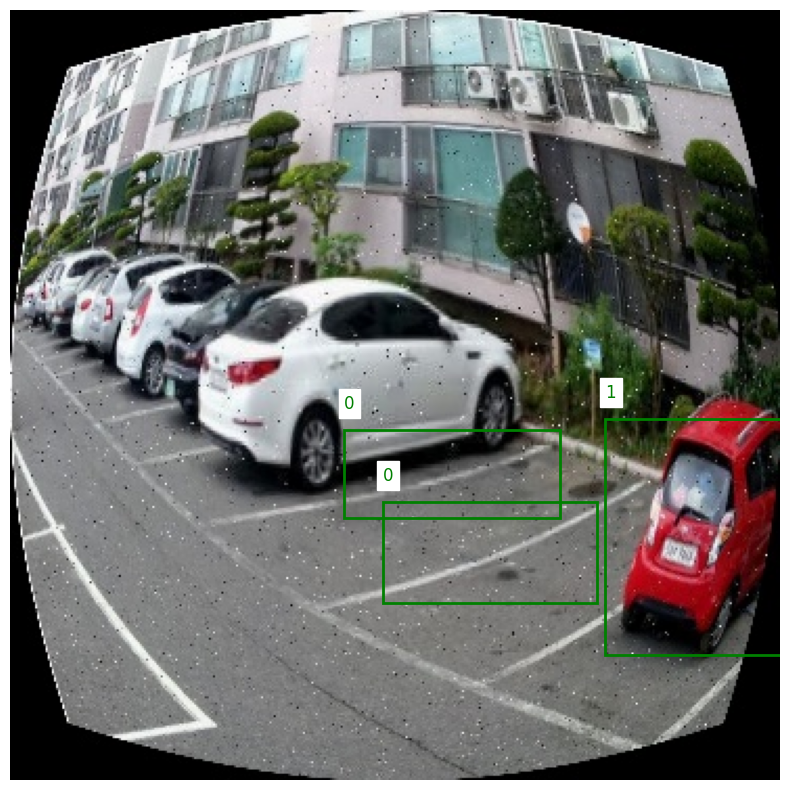

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def load_bounding_boxes(file_path, image_width, image_height):
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            label, cx, cy, w, h = map(float, parts)
            x_min = (cx - w / 2) * image_width
            y_min = (cy - h / 2) * image_height
            x_max = (cx + w / 2) * image_width
            y_max = (cy + h / 2) * image_height
            boxes.append((int(label), x_min, y_min, x_max, y_max))
    return boxes

# Параметры
image_path = "Parking Finder.v1i.yolov8/train/images/-2023-05-03-092932_png_jpg.rf.6d741db39fd8830ac771e7d69a08f7e1.jpg"  # Путь к изображению
label_path = "Parking Finder.v1i.yolov8/train/labels/-2023-05-03-092932_png_jpg.rf.6d741db39fd8830ac771e7d69a08f7e1.txt"  # Путь к файлу с метками

# Загружаем изображение
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертируем в RGB для matplotlib
image_height, image_width = image.shape[:2]

# Загружаем bounding boxes
boxes = load_bounding_boxes(label_path, image_width, image_height)

# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

# Рисуем bounding boxes
for label, x_min, y_min, x_max, y_max in boxes:
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 10, str(label), color='green', fontsize=12, backgroundcolor='white')

# Настройка и отображение
plt.axis('off')  # Отключаем оси
plt.show()
